# 確率的行列分解の修正
$n$回のセッションについて，$m$個の商品の評価が$R$という$n \times m$行列で与えられているものとする．
ここで$R$の要素$r_{s, i}$を以下のように定める：

>商品$i$がセッション$s$のビューに含まれている場合，$r_{s, i} = 1$ \
>商品$i$がセッション$s$で購入された場合，$r_{s, i} = r_{\rm purchase}$ \
>その他の場合，$r_{s, i} = 0$

ここで$r_{\rm purchase} > 1$と定めることで，購入されたという情報を取り入れることができるようにする．

# セットアップ

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import re
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tqdm import tqdm # for文の進捗状況を見るために使う

In [2]:
plt.style.use("ggplot")
plt.rcParams['font.family'] = "MS Gothic"
plt.rcParams["font.size"] = 20

# データの読み込み
開くとそれぞれのデータがどのような形か確認できるようになっている

購入データ`df_train_purchases`

In [3]:
path_data = r'C:\Users\yota-\Desktop\study\mystudy\recsys\dressipi_recsys2022\data'
df_train_purchases = pd.read_csv(path_data + r"\train_purchases.csv")
display(df_train_purchases)

,session_id,item_id,date
0,3,15085,2020-12-18 21:26:47.986
1,13,18626,2020-03-13 19:36:15.507
2,18,24911,2020-08-26 19:20:32.049
3,19,12534,2020-11-02 17:16:45.92
4,24,13226,2020-02-26 18:27:44.114
...,...,...,...
999995,4439986,2915,2021-05-13 11:56:37.464
999996,4439990,8786,2020-08-22 14:28:22.382
999997,4439994,21630,2020-11-27 20:10:28.961
999998,4439999,16962,2020-11-27 11:01:41.356


セッションのデータ`df_train_sessions`

In [4]:
df_train_sessions = pd.read_csv(path_data + r"\train_sessions.csv")
display(df_train_sessions)

,session_id,item_id,date
0,3,9655,2020-12-18 21:25:00.373
1,3,9655,2020-12-18 21:19:48.093
2,13,15654,2020-03-13 19:35:27.136
3,18,18316,2020-08-26 19:18:30.833
4,18,2507,2020-08-26 19:16:31.211
...,...,...,...
4743815,4440001,20409,2020-10-30 23:37:20.658
4743816,4440001,14155,2020-10-30 23:31:56.607
4743817,4440001,14303,2020-10-30 23:36:17.934
4743818,4440001,27852,2020-10-30 23:39:55.186


商品の候補一覧`df_candidate_items`

In [5]:
df_candidate_items = pd.read_csv(path_data + r"\candidate_items.csv")
display(df_candidate_items)

,item_id
0,4
1,8
2,9
3,19
4,20
...,...
4985,28128
4986,28131
4987,28132
4988,28133


特徴量データ`df_item_features`

In [6]:
df_item_features = pd.read_csv(path_data + r"\item_features.csv")
display(df_item_features)

,item_id,feature_category_id,feature_value_id
0,2,56,365
1,2,62,801
2,2,68,351
3,2,33,802
4,2,72,75
...,...,...,...
471746,28143,68,351
471747,28143,55,390
471748,28143,11,109
471749,28143,73,91


テストデータ`df_test_leaderboard`

In [7]:
df_test_leaderboard = pd.read_csv(path_data + r"\test_leaderboard_sessions.csv")
display(df_test_leaderboard)

,session_id,item_id,date
0,26,19185,2021-06-16 09:53:54.158
1,200,17089,2021-06-25 12:23:40.811
2,200,17089,2021-06-25 12:24:36.631
3,200,8060,2021-06-25 12:24:41.677
4,200,4758,2021-06-25 12:24:50.692
...,...,...,...
229349,4439653,25955,2021-06-11 10:22:57.47
229350,4439653,12179,2021-06-11 10:23:00.663
229351,4439757,2078,2021-06-30 11:42:15.073
229352,4439757,2078,2021-06-30 11:43:13.725


# Rの代わりになるテーブルを作成
$R$はテーブルとして大きすぎるので，縦持ちのままインデックスの名前を変えることで対応．

In [8]:
r_purchases = 3.0

df_R = df_train_sessions.copy()
df_R.drop_duplicates(subset = ["session_id", "item_id"], inplace = True) # 重複があるため削除，個々の処理は要検討
df_R["eval"] = 1 # 何も考えず1を入れる．セッションsのビューに商品iが含まれているときr_{s,i}=1となるような感じ．
df_train_purchases["eval"] = r_purchases

df_R = pd.concat([df_R, df_train_purchases], axis = 0) # ビューのデータと購入データを縦に結合

df_R.index = df_R["session_id"].astype("str") + "-" + df_R["item_id"].astype("str") # 複合キーを作成(少し時間がかかる)
display(df_R)

,session_id,item_id,date,eval
3-9655,3,9655,2020-12-18 21:25:00.373,1.0
13-15654,13,15654,2020-03-13 19:35:27.136,1.0
18-18316,18,18316,2020-08-26 19:18:30.833,1.0
18-2507,18,2507,2020-08-26 19:16:31.211,1.0
18-4026,18,4026,2020-08-26 19:15:47.232,1.0
...,...,...,...,...
4439986-2915,4439986,2915,2021-05-13 11:56:37.464,3.0
4439990-8786,4439990,8786,2020-08-22 14:28:22.382,3.0
4439994-21630,4439994,21630,2020-11-27 20:10:28.961,3.0
4439999-16962,4439999,16962,2020-11-27 11:01:41.356,3.0


# 確率的行列分解を実装
Symplectic Euler的な更新になっていることに注意．

In [9]:
# 行列分解するクラス
# df_Rはsession_id, item, evaluationを縦持ちで保存しているデータフレーム
# df_item_featuresは商品の特徴量をまとめている，セッションに出てこない商品も含めるためだけに使う
# k_dimは取り出したい特徴量の次元

class matrix_factorization:
    def __init__(self, df_R, df_item_features, k_dim, lambda_p = 0.1, lambda_q = 0.1):
        # いろいろ代入
        self.df_R = df_R.drop_duplicates(subset = ["session_id", "item_id"]) # 重複があると嫌なので削除
        self.k_dim = k_dim
        self.lambda_p = lambda_p
        self.lambda_q = lambda_q
        
        # パラメーター
        self.feature_name_list = ["feature{}".format(x + 1) for x in range(k_dim)]
        num_session = len(df_R["session_id"].unique())
        num_item = len(df_item_features["item_id"].unique())
        
        # PとQを表すデータフレーム
        self.df_P = pd.DataFrame(np.random.randn(k_dim, num_session), columns = self.df_R["session_id"].unique(), index = self.feature_name_list)
        self.df_Q = pd.DataFrame(np.random.randn(k_dim, num_item), columns = df_item_features["item_id"].unique(), index = self.feature_name_list)
        
        # idからnumpy行列のインデックスに変換するための辞書
        self.dict_session_to_idx = dict( zip(self.df_P.columns, range(len(self.df_P.columns))) )
        self.dict_item_to_idx = dict( zip(self.df_Q.columns, range(len(self.df_Q.columns))) )
    
    def update(self, alpha, num_iteration): # matrix factorizationの更新式を実行．alphaは更新速度，num_iterationは更新の繰り返しの回数
        # データフレームだと遅すぎるのでnumpyベースで計算
        P = self.df_P.values
        Q = self.df_Q.values
        
        self.loss_list = [[] for _ in range(num_iteration)] # 損失関数をプロットするためのレコード
        
        for t in range(num_iteration):
            # 損失関数の計算
            loss = 0.5 * self.lambda_p * np.linalg.norm(P, "fro") ** 2.0 # Frobenius norm
            loss += 0.5 * self.lambda_q * np.linalg.norm(Q, "fro") ** 2.0

            # 全体のシフトを一発で終わらせる
            P = P * (1.0 - alpha*self.lambda_p)
            Q = Q * (1.0 - alpha*self.lambda_q)
            
            # 進捗状況を表示するためのあれこれ(tqdmは関数内ではうまく使えなさそう)
            time_start = datetime.datetime.now()
            idx_step = 100000
            len_df_R = len(self.df_R["session_id"])
            
            # 評価がなされているペアに対しての処理
            for idx, (s, i, r_s_i) in enumerate(zip(self.df_R["session_id"], self.df_R["item_id"], self.df_R["eval"])): # 高速化するため列で取り出す
                # s：セッションid，i：商品id，r_s_i：セッションiにおける商品iの評価
                
                # 進捗状況を表示
                if idx % idx_step == 1:
                    time_now = datetime.datetime.now()
                    time_end_expected = time_start + (time_now - time_start) * (len_df_R / (idx+1))
                    print("終了時刻(予測):", time_end_expected.strftime("%H:%M:%S"), \
                          ",  進捗：", idx+1, "/", len_df_R, "({:.2%})".format(idx/len_df_R), end = "\r")
                
                # numpy用のidxに変換
                s_idx = self.dict_session_to_idx[s]
                i_idx = self.dict_item_to_idx[i]

                # パラメータの更新
                p_vec_s = P[:, s_idx]
                q_vec_i = Q[:, i_idx]

                P[:, s_idx] += alpha * (r_s_i - p_vec_s.dot(q_vec_i)) * q_vec_i
                Q[:, i_idx] += alpha * (r_s_i - p_vec_s.dot(q_vec_i)) * p_vec_s

                # 損失関数の計算(更新後の値が混ざっているため正確ではない)
                loss += (r_s_i - p_vec_s.dot(q_vec_i)) ** 2.0
            
            print("経過時間(実績)　=", time_now - time_start, "\n")
            
            print("t = ", t, "loss = ", loss)
            self.loss_list[t] = loss
        self.df_P = pd.DataFrame(P, index = self.df_P.index, columns = self.df_P.columns)
        self.df_Q = pd.DataFrame(Q, index = self.df_Q.index, columns = self.df_Q.columns)
    
    # これはあまり使わない
    def vectorize_session(self, item_id_list, eval_list): # ビューに含まれる商品からセッションをベクトル化．
        # item_id_listはビューに含まれる商品idのリスト，eval_listは各商品の評価のリスト．
        p_vec_s = np.zeros(self.k_dim)
        Q_s = np.zeros((self.k_dim, self.k_dim))
        for idx, item_id in enumerate(item_id_list):
            q_vec_i = self.df_Q[item_id].values
            Q_s += np.outer(q_vec_i, q_vec_i)
            p_vec_s += eval_list[idx] * q_vec_i
        p_vec_s = np.linalg.inv(self.lambda_p*np.eye(self.k_dim) + Q_s).dot(p_vec_s)
        return p_vec_s
    
    # これもあまり使わない
    def linear_regression_on_feature_space(self, df_train_purchases): # 購入データに基づいて，セッションのベクトルから購入された商品ベクトルを推測する線形モデル
        df_Q_tilde = pd.merge(df_train_purchases, self.df_Q_tilde.T, left_on = "item_id", right_index = True, how = "left")
        Q_tilde = df_Q_tilde[self.feature_name_list].values
        P = self.df_P.values
        self.T_coef = np.linalg.inv(P.dot(P.T)).dot(P).dot(Q_tilde)
        return self.T_coef
    
    # セッションsのビューに含まれる商品の一覧item_id_listに基づいて商品ベクトルの重心を計算し，
    # 候補となる商品の中から近い商品ベクトルを持つものを探す
    def search_nearest_neighborhood(self, item_id_list, df_candidate_items_on_Q):
        # 商品ベクトルQ上の重心によるモデル
        weight = np.arange(1, len(item_id_list)+1, 1) # 直近のデータをより大きく重みづけ
        weight = weight / sum(weight)
        q_vec_s = self.df_Q.T.loc[item_id_list].T.dot(weight).values # セッションsのビューに含まれる商品の重心を計算(よく考えるとわかる)
        
        df_distance = (df_candidate_items_on_Q - q_vec_s) * (df_candidate_items_on_Q - q_vec_s)
        df_distance = df_distance.sum(axis = 1).to_frame().sort_values(by = 0, ascending = True)
        index_to_drop = df_distance.index.isin(item_id_list) # ビューに含まれる商品は解答にならないはず
        df_distance = df_distance[~index_to_drop]
        return df_distance.index.values
    
    def predict_items(self, df_test_leaderboard, df_candidate_items, num_prediction = 100):
        session_id_list = df_test_leaderboard["session_id"].unique() # テストデータに含まれるセッションの一覧
        
        # predictionのための空のデータフレームを用意
        df_pred = pd.DataFrame(columns = ["session_id", "item_id", "rank"], index = range(len(session_id_list)*num_prediction))
        df_pred["session_id"] = np.repeat(session_id_list, num_prediction, axis = 0) # session_idは先に埋める
        df_pred["rank"] = np.tile(range(1, num_prediction+1), len(session_id_list)) # rankも埋める
        item_id_values = np.zeros(len(df_pred)) # pandasのlocで埋めると時間がかかるので，ndarrayに予測ラベルを埋めていく
        
        # 進捗状況を表示するためのあれこれ(tqdmは関数内ではうまく使えなさそう)
        time_start = datetime.datetime.now()
        idx_step = 100
        
        # 候補となる商品を特徴量空間上で表示
        df_candidate_items_on_Q = pd.merge(df_candidate_items, self.df_Q.T, left_on = "item_id", right_index = True, how = "left")
        df_candidate_items_on_Q.set_index("item_id", inplace = True)
        
        for idx, session_id in enumerate(session_id_list):
            # 進捗状況を表示
            if idx % idx_step == 1:
                time_now = datetime.datetime.now()
                time_end_expected = time_start + (time_now - time_start) * (len(session_id_list) / idx)
                print("終了時刻(予測):", time_end_expected.strftime("%H:%M:%S"), \
                      ",  進捗：", idx, "/", len(session_id_list), "({:.2%})".format(idx/len(session_id_list)), end = "\r")
            
            # このセッションについて，ビューに含まれるitemのリストを取得
            item_id_list = df_test_leaderboard[df_test_leaderboard["session_id"] == session_id]["item_id"].values
            # 特徴量空間から，予測したリストを取得
            pred_list = self.search_nearest_neighborhood(item_id_list, df_candidate_items_on_Q)[0:num_prediction]
            item_id_values[idx*num_prediction: (idx+1)*num_prediction] = np.array(pred_list) # pandasのlocで埋めると時間がかかるため，ndarrayを使う
            
        print("経過時間(実績)　=", time_now - time_start, "\n") 
        df_pred["item_id"] = item_id_values # 一気に埋める
        df_pred["item_id"] = df_pred["item_id"].astype("int")
        return df_pred

matrix factorizationiを実行．かなり時間がかかる．

In [11]:
k_dim = 100
model = matrix_factorization(df_R, df_item_features, k_dim, lambda_p = 0.1)

path_data_temp = r'C:\Users\yota-\Desktop\study\mystudy\recsys\dressipi_recsys2022\data\temp'
model.df_P = pd.read_pickle(path_data_temp + r'\df_P_matrix_factorization_k' + str(k_dim) + r'.pkl')
model.df_Q = pd.read_pickle(path_data_temp + r'\df_Q_matrix_factorization_k' + str(k_dim) + r'.pkl')

model.update(alpha = 0.05, num_iteration = 100)

経過時間(実績)　= 0:02:17.017669 5100002 / 5108850 (99.83%)

t =  0 loss =  756411.0968968136
経過時間(実績)　= 0:02:20.533057 5100002 / 5108850 (99.83%)

t =  1 loss =  128365.75690098353
経過時間(実績)　= 0:02:17.332715 5100002 / 5108850 (99.83%)

t =  2 loss =  81728.47876484672
経過時間(実績)　= 0:02:19.739581 5100002 / 5108850 (99.83%)

t =  3 loss =  67000.05593208688
経過時間(実績)　=07:30:29 ,  進捗： 5100002 / 5108850 (99.83%) 0:02:09.725562 

t =  4 loss =  62688.67923171983
経過時間(実績)　= 0:02:19.814860 5100002 / 5108850 (99.83%)

t =  5 loss =  60692.94049470909
経過時間(実績)　= 0:02:59.710383 5100002 / 5108850 (99.83%)

t =  6 loss =  58423.58089860188
経過時間(実績)　= 0:03:05.403129 5100002 / 5108850 (99.83%)

t =  7 loss =  57502.56549142425
経過時間(実績)　=07:41:29 ,  進捗： 5100002 / 5108850 (99.83%) 0:02:32.360641 

t =  8 loss =  56891.51068885329
経過時間(実績)　= 0:02:20.259797 5100002 / 5108850 (99.83%)

t =  9 loss =  56493.889203523264
経過時間(実績)　= 0:02:18.865202 5100002 / 5108850 (99.83%)

t =  10 loss =  56144.371698756
経過時間(実績)　=

経過時間(実績)　= 0:02:12.242280 5100002 / 5108850 (99.83%)

t =  92 loss =  49436.05395003146
経過時間(実績)　= 0:02:15.640062 5100002 / 5108850 (99.83%)

t =  93 loss =  49379.78739374119
経過時間(実績)　= 0:02:19.490236 5100002 / 5108850 (99.83%)

t =  94 loss =  49323.97514544132
経過時間(実績)　= 0:02:17.914641 5100002 / 5108850 (99.83%)

t =  95 loss =  49268.61486995
経過時間(実績)　= 0:02:17.654567 5100002 / 5108850 (99.83%)

t =  96 loss =  49213.70418467245
経過時間(実績)　= 0:02:16.753078 5100002 / 5108850 (99.83%)

t =  97 loss =  49159.240662581884
経過時間(実績)　= 0:02:17.952823 5100002 / 5108850 (99.83%)

t =  98 loss =  49105.221835193086
経過時間(実績)　= 0:02:16.859923 5100002 / 5108850 (99.83%)

t =  99 loss =  49051.64519527976


# パラメータチューニング
現状だと少し厳しいので，いい感じにチューニング

In [12]:
# df_targetは正解ラベル，列には["session_id", "item_id"]が必要．
# df_predはsubmitと同様の順位表，列には["session_id", "item", "rank"]が必要．
def mean_reciprocal_rank(df_target, df_pred):
    df_MRR = pd.merge(df_train_purchases,df_pred, how = "left", on = ["session_id", "item_id"]) # 各セッションごとに，購入された商品の順位を記録
    df_MRR["reciprocal_rank"] = 1.0 / df_MRR["rank"] # reciprocal rankを計算
    df_MRR["reciprocal_rank"].fillna(0.0, inplace = True) # 順位がない場合はreciprocal rankは0になる
    return df_MRR["reciprocal_rank"].mean() # 平均値がMRRになる

## データセットの分割

In [13]:
# ランダムに抽出
session_list = df_train_purchases["session_id"].unique()

r_purchases = 3.0 # 購入データに対する重み
train_ratio = 0.99
train_num = int(len(session_list) * train_ratio)
np.random.shuffle(session_list)
session_list_train = session_list[0: train_num]
session_list_test = session_list[train_num: ]

def split_data(df_train_sessions, df_train_purchases, session_list_temp):
    df_train_sessions_temp = df_train_sessions[df_train_sessions["session_id"].isin(session_list_temp)].copy()
    df_train_purchases_temp = df_train_purchases[df_train_purchases["session_id"].isin(session_list_temp)].copy()
    df_R_temp = df_train_sessions_temp.copy()
    df_R_temp.drop_duplicates(subset = ["session_id", "item_id"], inplace = True) # 重複があるため削除，個々の処理は要検討
    df_R_temp["eval"] = 1 # 何も考えず1を入れる．セッションsのビューに商品iが含まれているときr_{s,i}=1となるような感じ．
    df_train_purchases_temp["eval"] = r_purchases
    df_R_temp = pd.concat([df_R_temp, df_train_purchases_temp], axis = 0) # ビューのデータと購入データを縦に結合
    df_R_temp.index = df_R_temp["session_id"].astype("str") + "-" + df_R_temp["item_id"].astype("str") # 複合キーを作成(少し時間がかかる)
    return df_train_sessions_temp, df_train_purchases_temp, df_R_temp

# 訓練データ
df_train_sessions_train, df_train_purchases_train, df_R_train = split_data(df_train_sessions, df_train_purchases, session_list_train)
# テストデータ
df_train_sessions_test, df_train_purchases_test, df_R_test = split_data(df_train_sessions, df_train_purchases, session_list_test)

In [39]:
k_dim = 100
model = matrix_factorization(df_R_train, df_item_features, k_dim, lambda_p = 0.1)

path_data_temp = r'C:\Users\yota-\Desktop\study\mystudy\recsys\dressipi_recsys2022\data\temp'
model.df_P = pd.read_pickle(path_data_temp + r'\df_P_matrix_factorization_k' + str(k_dim) + r'.pkl')
model.df_Q = pd.read_pickle(path_data_temp + r'\df_Q_matrix_factorization_k' + str(k_dim) + r'.pkl')

model.update(alpha = 0.05, num_iteration = 5)

100%|█████████████████████████████████████████████████████████████████████| 5057959/5057959 [01:43<00:00, 48774.04it/s]


t =  0 loss =  603686.7520782083


100%|█████████████████████████████████████████████████████████████████████| 5057959/5057959 [01:38<00:00, 51265.32it/s]


t =  1 loss =  713167.7530451444


100%|█████████████████████████████████████████████████████████████████████| 5057959/5057959 [01:39<00:00, 50639.77it/s]


t =  2 loss =  372934.9914501005


100%|█████████████████████████████████████████████████████████████████████| 5057959/5057959 [01:41<00:00, 49883.88it/s]


t =  3 loss =  211289.92105069413


100%|█████████████████████████████████████████████████████████████████████| 5057959/5057959 [01:44<00:00, 48600.77it/s]

t =  4 loss =  137828.40176055647


In [14]:
# df_targetは正解ラベル，列には["session_id", "item_id"]が必要．
# df_predはsubmitと同様の順位表，列には["session_id", "item", "rank"]が必要．
def mean_reciprocal_rank(df_target, df_pred):
    df_MRR = pd.merge(df_train_purchases,df_pred, how = "left", on = ["session_id", "item_id"]) # 各セッションごとに，購入された商品の順位を記録
    df_MRR["reciprocal_rank"] = 1.0 / df_MRR["rank"] # reciprocal rankを計算
    df_MRR["reciprocal_rank"].fillna(0.0, inplace = True) # 順位がない場合はreciprocal rankは0になる
    return df_MRR["reciprocal_rank"].mean() # 平均値がMRRになる

In [41]:
df_submit = model.predict_items(df_train_sessions_test, df_candidate_items)
mean_reciprocal_rank(df_train_purchases_test, df_submit)

経過時間(実績)　= 0:03:04.662527 9901 / 10000 (99.01%)



NameError: name 'mean_reciprocal_rank' is not defined

In [43]:
mean_reciprocal_rank(df_train_purchases_test, df_submit)

3.6931044593873325e-06

# いろんなパラメータで試す

In [15]:
lambda_p_start = 0.0001
lambda_p_end = 100.0
lambda_p_num = 7
lambda_p_list = np.geomspace(lambda_p_start, lambda_p_end, lambda_p_num)
lambda_p_list

array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

lambda_p =  0.0001
経過時間(実績)　= 0:02:15.854166 5000002 / 5057932 (98.85%)

t =  0 loss =  631333.2025170879
経過時間(実績)　= 0:02:17.054911 5000002 / 5057932 (98.85%)

t =  1 loss =  85663.45722691147
経過時間(実績)　= 0:02:17.029952 5000002 / 5057932 (98.85%)

t =  2 loss =  45107.526230439515
経過時間(実績)　= 0:02:19.357755 5000002 / 5057932 (98.85%)

t =  3 loss =  26466.942323944924
経過時間(実績)　= 0:02:17.699930 5000002 / 5057932 (98.85%)

t =  4 loss =  22551.332441160117
経過時間(実績)　= 0:02:17.214725 5000002 / 5057932 (98.85%)

t =  5 loss =  20057.219373302825
経過時間(実績)　= 0:02:15.152954 5000002 / 5057932 (98.85%)

t =  6 loss =  18326.760671284967
経過時間(実績)　= 0:02:16.431712 5000002 / 5057932 (98.85%)

t =  7 loss =  17315.0165420781
経過時間(実績)　= 0:02:15.633444 5000002 / 5057932 (98.85%)

t =  8 loss =  17284.243122964985
経過時間(実績)　= 0:02:15.508598 5000002 / 5057932 (98.85%)

t =  9 loss =  16804.297872313193
経過時間(実績)　= 0:02:15.197539 5000002 / 5057932 (98.85%)

t =  10 loss =  15189.365968048012
経過時間(実績)　= 0:02:

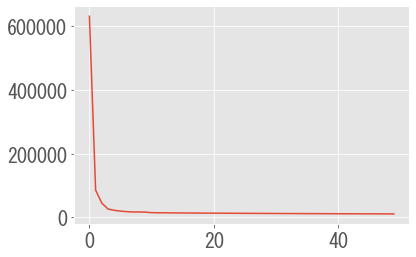

経過時間(実績)　= 0:03:53.763944 9901 / 10000 (99.01%)

2.4746270175494475e-06
lambda_p =  0.001
経過時間(実績)　= 0:02:16.463621 5000002 / 5057932 (98.85%)

t =  0 loss =  631564.9900193479
経過時間(実績)　= 0:02:16.645525 5000002 / 5057932 (98.85%)

t =  1 loss =  86014.94748137471
経過時間(実績)　= 0:02:18.019504 5000002 / 5057932 (98.85%)

t =  2 loss =  45471.863227588234
経過時間(実績)　= 0:02:19.072201 5000002 / 5057932 (98.85%)

t =  3 loss =  26849.172173923136
経過時間(実績)　= 0:02:19.287718 5000002 / 5057932 (98.85%)

t =  4 loss =  22949.34797515296
経過時間(実績)　= 0:02:17.473020 5000002 / 5057932 (98.85%)

t =  5 loss =  20460.238753594498
経過時間(実績)　= 0:02:16.602062 5000002 / 5057932 (98.85%)

t =  6 loss =  18706.437011572547
経過時間(実績)　= 0:02:17.020762 5000002 / 5057932 (98.85%)

t =  7 loss =  17733.27678990436
経過時間(実績)　= 0:02:17.956014 5000002 / 5057932 (98.85%)

t =  8 loss =  17715.927215406267
経過時間(実績)　= 0:02:16.502969 5000002 / 5057932 (98.85%)

t =  9 loss =  17219.425574349145
経過時間(実績)　= 0:02:16.583384 5000002 

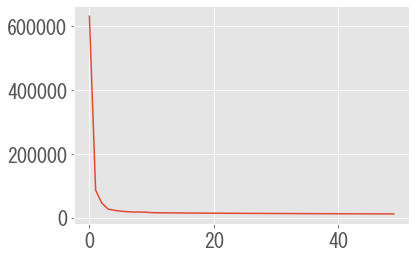

経過時間(実績)　= 0:04:06.391154 9901 / 10000 (99.01%)

2.4477324208828825e-06
lambda_p =  0.01
経過時間(実績)　= 0:02:23.904994 5000002 / 5057932 (98.85%)

t =  0 loss =  633882.6033058059
経過時間(実績)　= 0:02:23.140854 5000002 / 5057932 (98.85%)

t =  1 loss =  89528.42584688084
経過時間(実績)　= 0:02:23.211241 5000002 / 5057932 (98.85%)

t =  2 loss =  49112.01138540328
経過時間(実績)　= 0:02:23.365539 5000002 / 5057932 (98.85%)

t =  3 loss =  30666.23891786307
経過時間(実績)　= 0:02:22.116655 5000002 / 5057932 (98.85%)

t =  4 loss =  26921.32178085703
経過時間(実績)　= 0:02:26.199000 5000002 / 5057932 (98.85%)

t =  5 loss =  24500.858938463753
経過時間(実績)　= 0:02:25.096046 5000002 / 5057932 (98.85%)

t =  6 loss =  21834.240198571944
経過時間(実績)　= 0:02:22.599895 5000002 / 5057932 (98.85%)

t =  7 loss =  22048.644924393368
経過時間(実績)　= 0:02:23.561115 5000002 / 5057932 (98.85%)

t =  8 loss =  22251.464575491154
経過時間(実績)　= 0:02:22.413898 5000002 / 5057932 (98.85%)

t =  9 loss =  21141.777109835264
経過時間(実績)　= 0:02:23.124662 5000002 / 

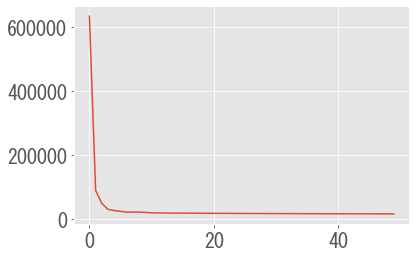

経過時間(実績)　= 0:04:20.021811 9901 / 10000 (99.01%)

2.3103843190560087e-06
lambda_p =  0.1
経過時間(実績)　= 0:02:33.894327 5000002 / 5057932 (98.85%)

t =  0 loss =  657033.0655988372
経過時間(実績)　= 0:02:31.704722 5000002 / 5057932 (98.85%)

t =  1 loss =  124518.26126692242
経過時間(実績)　= 0:02:32.143380 5000002 / 5057932 (98.85%)

t =  2 loss =  85191.28072282003
経過時間(実績)　= 0:02:31.446768 5000002 / 5057932 (98.85%)

t =  3 loss =  68390.2047098282
経過時間(実績)　= 0:02:30.895017 5000002 / 5057932 (98.85%)

t =  4 loss =  65541.82567094233
経過時間(実績)　= 0:02:34.155415 5000002 / 5057932 (98.85%)

t =  5 loss =  64537.97950600379
経過時間(実績)　= 0:02:31.858338 5000002 / 5057932 (98.85%)

t =  6 loss =  61410.20245746205
経過時間(実績)　= 0:02:31.597698 5000002 / 5057932 (98.85%)

t =  7 loss =  60734.006003379975
経過時間(実績)　= 0:02:32.913536 5000002 / 5057932 (98.85%)

t =  8 loss =  60928.90253620773
経過時間(実績)　= 0:02:30.942250 5000002 / 5057932 (98.85%)

t =  9 loss =  61293.88465038327
経過時間(実績)　= 0:02:32.388103 5000002 / 50579

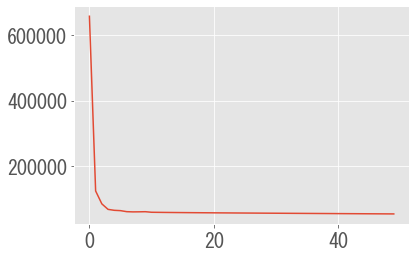

経過時間(実績)　= 0:04:06.767057 9901 / 10000 (99.01%)

1.359083393632616e-06
lambda_p =  1.0
経過時間(実績)　= 0:02:23.963485 5000002 / 5057932 (98.85%)

t =  0 loss =  888137.7341990445
経過時間(実績)　= 0:02:24.996032 5000002 / 5057932 (98.85%)

t =  1 loss =  461457.0470375822
経過時間(実績)　= 0:02:23.033024 5000002 / 5057932 (98.85%)

t =  2 loss =  416275.2549670533
経過時間(実績)　= 0:02:22.843152 5000002 / 5057932 (98.85%)

t =  3 loss =  401631.10814753734
経過時間(実績)　= 0:02:18.502996 5000002 / 5057932 (98.85%)

t =  4 loss =  394113.0605267638
経過時間(実績)　= 0:02:18.155996 5000002 / 5057932 (98.85%)

t =  5 loss =  384894.353759976
経過時間(実績)　= 0:02:19.038849 5000002 / 5057932 (98.85%)

t =  6 loss =  375970.34566620714
経過時間(実績)　= 0:02:21.419172 5000002 / 5057932 (98.85%)

t =  7 loss =  366549.1817651595
経過時間(実績)　= 0:02:21.238683 5000002 / 5057932 (98.85%)

t =  8 loss =  358330.83334120514
経過時間(実績)　= 0:02:19.002275 5000002 / 5057932 (98.85%)

t =  9 loss =  351070.8144242323
経過時間(実績)　= 0:02:17.421817 5000002 / 50579

In [ ]:
num_iteration = 50
score_list = []

for lambda_p in lambda_p_list:
    # モデルの作成
    print("lambda_p = ", lambda_p)
    model = matrix_factorization(df_R_train, df_item_features, k_dim, lambda_p = lambda_p)
    model.df_P = pd.read_pickle(path_data_temp + r'\df_P_matrix_factorization_k' + str(k_dim) + r'.pkl')
    model.df_Q = pd.read_pickle(path_data_temp + r'\df_Q_matrix_factorization_k' + str(k_dim) + r'.pkl')
    
    # モデルの更新，プロット
    model.update(alpha = 0.05, num_iteration = num_iteration)
    plt.plot(range(len(model.loss_list)), model.loss_list)
    plt.show()
    
    # スコアの算出
    df_submit = model.predict_items(df_train_sessions_test, df_candidate_items)
    score_lambda = mean_reciprocal_rank(df_train_purchases_test, df_submit)
    score_list.append(score_lambda)
    print(score_lambda)

In [ ]:
plt.plot(lambda_p_list, score_list)
plt.xscale("log")
plt.show()

経過時間(実績)　= 0:01:14.498203 5000002 / 5058763 (98.84%)

t =  0 loss =  2928560.9016219536
経過時間(実績)　= 0:01:38.242146 5000002 / 5058763 (98.84%)

t =  1 loss =  2549100.8716400424
経過時間(実績)　= 0:02:10.406354 5000002 / 5058763 (98.84%)

t =  2 loss =  2377664.8035321804
経過時間(実績)　= 0:02:21.180418 5000002 / 5058763 (98.84%)

t =  3 loss =  2255370.175291358
経過時間(実績)　= 0:01:39.851749 5000002 / 5058763 (98.84%)

t =  4 loss =  2143325.076534704
経過時間(実績)　= 0:01:54.155247 5000002 / 5058763 (98.84%)

t =  5 loss =  2020236.9469943398
経過時間(実績)　= 0:01:33.371112 5000002 / 5058763 (98.84%)

t =  6 loss =  1881834.097038017
経過時間(実績)　= 0:01:37.497143 5000002 / 5058763 (98.84%)

t =  7 loss =  1732986.566474693
経過時間(実績)　= 0:01:33.299110 5000002 / 5058763 (98.84%)

t =  8 loss =  1587036.0126249946
経過時間(実績)　= 0:01:35.155622 5000002 / 5058763 (98.84%)

t =  9 loss =  1447517.8164891403
経過時間(実績)　= 0:01:38.073689 5000002 / 5058763 (98.84%)

t =  10 loss =  1314722.0085376084
経過時間(実績)　= 0:01:35.305123 5000002 /

経過時間(実績)　= 0:01:36.718637 5000002 / 5058763 (98.84%)

t =  93 loss =  19661.104757139332
経過時間(実績)　= 0:01:36.123127 5000002 / 5058763 (98.84%)

t =  94 loss =  19601.897941728803
経過時間(実績)　= 0:01:34.303618 5000002 / 5058763 (98.84%)

t =  95 loss =  19545.36016963038
経過時間(実績)　= 0:01:36.681632 5000002 / 5058763 (98.84%)

t =  96 loss =  19491.323391422116
経過時間(実績)　= 0:01:34.910102 5000002 / 5058763 (98.84%)

t =  97 loss =  19439.631384413053
経過時間(実績)　= 0:01:33.467609 5000002 / 5058763 (98.84%)

t =  98 loss =  19390.138802263184
経過時間(実績)　= 0:01:33.797116 5000002 / 5058763 (98.84%)

t =  99 loss =  19342.71031320525


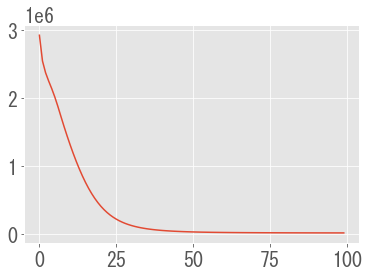

In [91]:
lambda_p = 0.01
model = matrix_factorization(df_R_train, df_item_features, k_dim, lambda_p = lambda_p)
model.df_P = pd.read_pickle(path_data_temp + r'\df_P_matrix_factorization_k' + str(k_dim) + r'.pkl')
model.df_Q = pd.read_pickle(path_data_temp + r'\df_Q_matrix_factorization_k' + str(k_dim) + r'.pkl')
model.update(alpha = 0.01, num_iteration = 100)

plt.plot(range(len(model.loss_list)), model.loss_list)

In [92]:
path_data_temp = r'C:\Users\yota-\Desktop\study\mystudy\recsys\dressipi_recsys2022\data\temp'
model.df_P.to_pickle(path_data_temp + r'\df_P_matrix_factorization_k' + str(k_dim) + r'.pkl')
model.df_Q.to_pickle(path_data_temp + r'\df_Q_matrix_factorization_k' + str(k_dim) + r'.pkl')